# kmeans 군집 

In [159]:
import pandas as pd
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

## 파일 불러오기

In [160]:
data = pd.read_csv('data/final_data.csv').drop(['기온'], axis=1)

In [161]:
data

,시간대,성별,연령대,지역,기분,1순위,2순위,3순위,강수량,습도,...,초밥,우동,메밀소바,돈가스,볶음밥,짜장면,짬뽕,날짜,시간,요일
0,2021-05-16 14:00:00,남자,청년,수도권,행복,한식,일식,중식,1.6,99.1,...,2,0,0,2,0,0,1,05-16,14,일
1,2021-05-16 15:00:00,여자,중장년,서울,분노,한식,중식,일식,1.4,97.0,...,0,0,1,0,2,0,0,05-16,15,일
2,2021-05-16 15:00:00,남자,청년,서울,중립,일식,양식,한식,1.4,97.0,...,0,0,3,3,0,0,0,05-16,15,일
3,2021-05-16 15:00:00,여자,청년,서울,행복,일식,한식,분식,1.4,97.0,...,3,0,0,0,0,0,0,05-16,15,일
4,2021-05-16 16:00:00,남자,청년,경상도,행복,양식,일식,분식,2.6,94.7,...,2,0,0,2,0,0,0,05-16,16,일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,2021-05-24 16:00:00,남자,노년,경상도,행복,한식,분식,중식,0.0,52.2,...,0,0,0,0,0,0,1,05-24,16,월
417,2021-05-24 16:00:00,남자,노년,수도권,행복,한식,일식,중식,0.0,45.1,...,0,0,2,0,0,1,0,05-24,16,월
418,2021-05-24 16:00:00,여자,노년,전라도,행복,한식,중식,일식,0.0,57.0,...,0,0,0,1,2,0,0,05-24,16,월
419,2021-05-24 16:00:00,남자,노년,전라도,우울,분식,양식,일식,0.0,57.0,...,0,0,1,0,0,0,0,05-24,16,월


## 컬럼 설정

In [162]:
# 평일 / 주말 구분 컬럼 생성

for i in range(len(data)):
    if data.loc[i, "요일"] == "일":
        data.loc[i, "휴일"] = "주말"
    else:
        data.loc[i, "휴일"] = "평일"

In [163]:
# 비 / 비안옴 구분 컬럼 생성

for i in range(len(data)):
    if data.loc[i, "강수량"] == 0:
        data.loc[i, "비"] = "비안옴"
    else:
        data.loc[i, "비"] ="비옴"

In [164]:
# 전운량 구분 컬럼 생성

data.loc[(data['전운량']>=0) & (data['전운량']<=5), '구름'] = "맑음"
data.loc[(data['전운량']>=6) & (data['전운량']<=8), '구름'] = "구름많음"
data.loc[(data['전운량']>=9) & (data['전운량']<=10), '구름'] = "흐림"

In [165]:
# 식사시간 구분 컬럼 생성

for i in range(len(data)):
    if data.loc[i, "시간"]>=16 and data.loc[i, "시간"]<=23:
        data.loc[i, "식사시간"] = "저녁"
    elif data.loc[i, "시간"]>=11 and data.loc[i, "시간"]<16:
        data.loc[i, "식사시간"] = '점심'
    else:
        data.loc[i, "식사시간"] = "아침"

# 분석

In [166]:
# 상관계수 확인

data.corr()

,강수량,습도,기압,전운량,불고기,냉면,칼국수,된장찌개,비빔밥,김치찌개,...,스테이크,햄버거,초밥,우동,메밀소바,돈가스,볶음밥,짜장면,짬뽕,시간
강수량,1.000000,0.646806,-0.700074,0.664715,0.001841,0.045296,0.129529,0.052960,0.063549,0.114980,...,0.188369,0.077200,-0.007127,0.066115,0.001464,0.066573,-0.000945,0.071957,0.116386,0.367359
습도,0.646806,1.000000,-0.397219,0.832120,0.003368,-0.020772,0.089629,0.070824,0.066317,0.125959,...,0.186695,0.110976,0.075729,0.111340,0.064341,0.117401,-0.027462,0.141485,0.063441,0.139990
기압,-0.700074,-0.397219,1.000000,-0.582468,0.028341,-0.000725,-0.037571,-0.000374,0.000924,-0.099495,...,-0.108811,-0.052877,0.064191,-0.030581,0.013056,0.024343,-0.046817,-0.105452,-0.180310,-0.418967
전운량,0.664715,0.832120,-0.582468,1.000000,-0.026188,-0.050169,0.055364,0.133753,0.007479,0.116974,...,0.122339,0.114186,0.055357,0.052953,0.031805,0.091980,0.018417,0.136597,0.080176,0.128252
불고기,0.001841,0.003368,0.028341,-0.026188,1.000000,0.144565,0.041496,0.054306,0.028985,0.070974,...,0.026404,0.051709,-0.001934,0.051623,-0.030632,0.028400,0.041174,0.010057,-0.096606,0.012085
냉면,0.045296,-0.020772,-0.000725,-0.050169,0.144565,1.000000,0.233113,0.071291,0.010261,0.100727,...,0.006052,0.025026,0.106389,0.051719,0.216055,0.006288,-0.080071,-0.060032,-0.066712,0.021120
칼국수,0.129529,0.089629,-0.037571,0.055364,0.041496,0.233113,1.000000,0.072767,0.120980,0.098153,...,0.043060,0.002461,0.048350,0.161043,0.110129,0.051587,-0.031574,-0.072844,-0.035171,0.001691
된장찌개,0.052960,0.070824,-0.000374,0.133753,0.054306,0.071291,0.072767,1.000000,0.048006,0.100960,...,0.027055,-0.053404,0.015352,0.142923,-0.037882,-0.036601,0.005448,-0.073512,-0.032777,-0.049114
비빔밥,0.063549,0.066317,0.000924,0.007479,0.028985,0.010261,0.120980,0.048006,1.000000,-0.000343,...,-0.030202,-0.093167,-0.001635,0.038992,0.036881,-0.025668,-0.041188,-0.037729,-0.064594,0.023361
김치찌개,0.114980,0.125959,-0.099495,0.116974,0.070974,0.100727,0.098153,0.100960,-0.000343,1.000000,...,-0.040497,0.043769,0.021576,0.063169,-0.017586,0.055798,0.036961,0.001255,0.079869,0.074653


# 데이터 전처리
* 더미화

* 표준화

In [167]:
# 파일 복사

df = data.copy()

In [168]:
total = df.loc[:,["성별", "연령대", "기분", "구름", "휴일", "식사시간", "비"]]

In [169]:
# 데이터 더미화

df_dummy = pd.get_dummies(total)
df_dummy

,성별_남자,성별_여자,연령대_노년,연령대_중장년,연령대_청년,연령대_청소년,기분_분노,기분_우울,기분_중립,기분_행복,구름_구름많음,구름_맑음,구름_흐림,휴일_주말,휴일_평일,식사시간_아침,식사시간_저녁,식사시간_점심,비_비안옴,비_비옴
0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1
1,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1
2,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1
3,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1
4,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
417,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
418,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
419,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0


In [170]:
# 데이터 표준화

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df_dummy))
data_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040


In [171]:
#표준화 모델 피클저장
import joblib

joblib.dump(scaler, 'data/scalemodel.pkl')

['data/scalemodel.pkl']

In [172]:
##표준화 결과 rename
data_scaled.rename(columns={0:'남자',1:'여자',2:'노년',3:'중장년',4:'청년',5:'청소년',6:'분노',7:'우울',8:'중립',
               9:'행복',10:'구름많음',11:'맑음',12:'흐림',13:'주말',14:'평일',15:'아침',16:'저녁',17:'점심',18:"비안옴",19:"비옴"},inplace=True)

In [173]:
data_scaled

,남자,여자,노년,중장년,청년,청소년,분노,우울,중립,행복,구름많음,맑음,흐림,주말,평일,아침,저녁,점심,비안옴,비옴
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040


In [174]:
kmedoids_data = data_scaled.copy()

# k-medio 모델



In [175]:
# kmedios 용 데이터 복사
kmedoids_data = data_scaled.copy()

### Elbow method

C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\

C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\

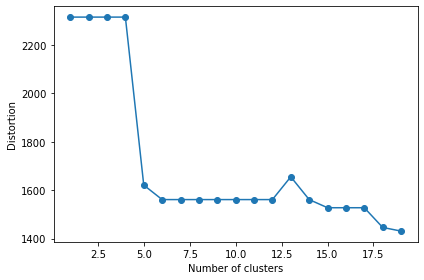

In [176]:
# Elbow method

dist =[]
for i in range(1,20):
    k = KMedoids(n_clusters=i, random_state=200)
    k.fit(kmedoids_data)
    dist.append(k.inertia_)

plt.plot(range(1,20),dist, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [177]:
np.random.seed(123)

total_sd_arr = kmedoids_data.values

# k값을 5로 설정 후, k-means에 적용시키기
kmedoids = KMedoids(n_clusters=5, random_state=200).fit(total_sd_arr)
kmedoids.cluster_centers_

C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


array([[ 0.83931725, -0.83931725, -0.36711155, -0.5214435 , -0.80683356,
         1.6312172 , -0.21740212, -0.48061851, -0.63876972,  1.04619662,
        -0.33289329, -0.88965688,  1.08689795,  1.4091897 , -1.4091897 ,
        -0.375395  ,  0.91565711, -0.70584746, -1.16273613,  1.16273613],
       [ 0.83931725, -0.83931725, -0.36711155, -0.5214435 ,  1.239413  ,
        -0.61303915, -0.21740212, -0.48061851,  1.5655094 , -0.95584327,
        -0.33289329,  1.12402885, -0.92004958, -0.70962767,  0.70962767,
        -0.375395  , -1.09211187,  1.41673669,  0.86004036, -0.86004036],
       [ 0.83931725, -0.83931725, -0.36711155, -0.5214435 ,  1.239413  ,
        -0.61303915, -0.21740212, -0.48061851, -0.63876972,  1.04619662,
        -0.33289329,  1.12402885, -0.92004958, -0.70962767,  0.70962767,
        -0.375395  ,  0.91565711, -0.70584746,  0.86004036, -0.86004036],
       [ 0.83931725, -0.83931725, -0.36711155, -0.5214435 ,  1.239413  ,
        -0.61303915, -0.21740212, -0.48061851, -

In [178]:
# 군집 labels 컬럼 추가

kmedoids_data['cluster'] = kmedoids.labels_
kmedoids_data

,남자,여자,노년,중장년,청년,청소년,분노,우울,중립,행복,...,맑음,흐림,주말,평일,아침,저녁,점심,비안옴,비옴,cluster
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,1
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2


### t-SNE

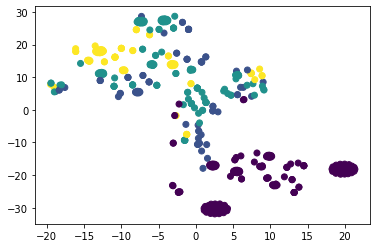

In [179]:
# t-SNE 시각화

model = TSNE(learning_rate=100)
transformed = model.fit_transform(kmedoids_data.iloc[:,:20])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=kmedoids.labels_)

plt.show()

# K-means 모델링

In [180]:
# 데이터 복제

kmeans_data = data_scaled.copy()
silhouette_data = data_scaled.copy()

### Elbow Method

In [181]:
def elbow(X):
    sse = []

    for i in range(1,20):
        km = KMeans(n_clusters=i, random_state=200)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,20), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


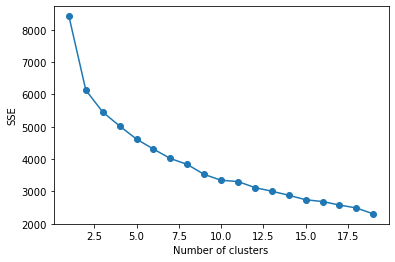

In [182]:
elbow(kmeans_data)

In [183]:
# 군집 개수 설정

kmeans = KMeans(n_clusters=5,
                random_state=200,
                init='k-means++',
                n_init=10,
                max_iter=300).fit(kmeans_data)

In [184]:
# 군집 labels 컬럼 추가

kmeans_data['cluster'] = kmeans.labels_
kmeans_data

,남자,여자,노년,중장년,청년,청소년,분노,우울,중립,행복,...,맑음,흐림,주말,평일,아침,저녁,점심,비안옴,비옴,cluster
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3


### Silhouette Method

In [185]:
%matplotlib inline

#추가 라벨이 붙지않는 오리지널 데이터(silhuette_data는 cluster나 silhouette_coeff같은 새 컬럼이 추가 될 예정)
origin_data = silhouette_data.copy()

silhouette_data['cluster'] = kmeans.labels_

# 모든 개별 데이터에 실루엣 계수값을 구함
score_samples = silhouette_samples(origin_data,silhouette_data['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# data 실루엣 계수 컬럼 추가
silhouette_data['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함
average_score = silhouette_score(origin_data, silhouette_data['cluster'])
print('데이터셋 Silhouette Analysis Score:'.format(average_score))
print(average_score)

silhouette_data.head(3)

silhouette_samples( ) return 값의 shape (421,)
데이터셋 Silhouette Analysis Score:
0.21418831720830994


,남자,여자,노년,중장년,청년,청소년,분노,우울,중립,행복,...,흐림,주말,평일,아침,저녁,점심,비안옴,비옴,cluster,silhouette_coeff
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.086898,1.40919,-1.40919,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0,0.064567
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,...,1.086898,1.40919,-1.40919,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0,0.009371
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,...,1.086898,1.40919,-1.40919,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0,0.090211


In [186]:
origin_data 

,남자,여자,노년,중장년,청년,청소년,분노,우울,중립,행복,구름많음,맑음,흐림,주말,평일,아침,저녁,점심,비안옴,비옴
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040


In [187]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        clusterer = KMeans(n_clusters = n_cluster, max_iter=300, random_state=200)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

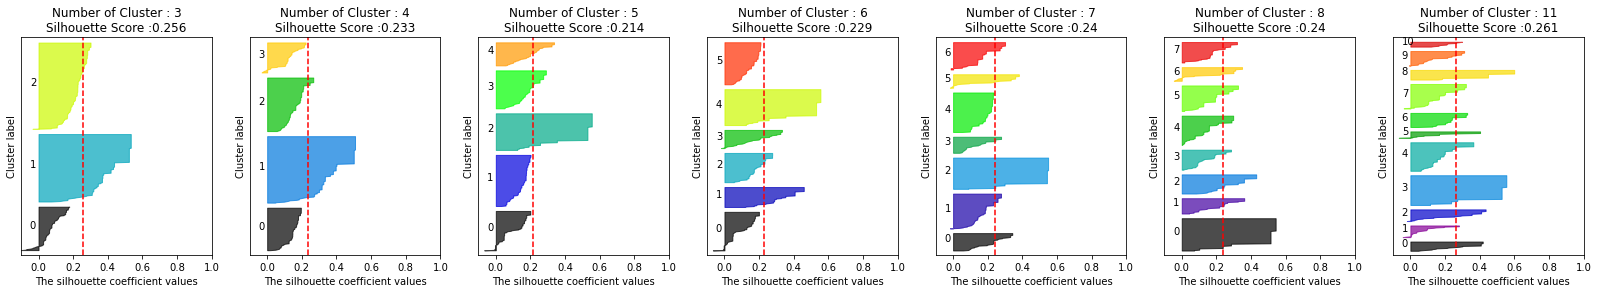

In [188]:
visualize_silhouette([3,4,5,6,7,8,11], origin_data)

### t-SNE

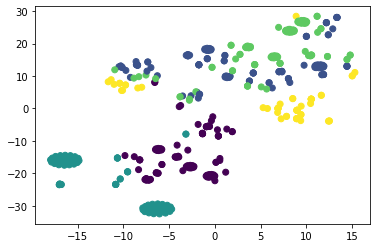

In [189]:
# t-SNE 시각화

model = TSNE(learning_rate=100)
transformed = model.fit_transform(origin_data)

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=kmeans.labels_)

plt.show()

In [190]:
kmeans_data.groupby("cluster").mean()

,남자,여자,노년,중장년,청년,청소년,분노,우울,중립,행복,구름많음,맑음,흐림,주말,평일,아침,저녁,점심,비안옴,비옴
cluster,,,,,,,,,,,,,,,,,,,,
0,-0.106833,0.106833,-0.331986,-0.216544,0.960379,-0.613039,-0.107921,0.043278,0.288029,-0.250579,-0.105380,-0.866774,0.927254,0.759098,-0.759098,-0.375395,0.368084,-0.126961,-1.139750,1.139750
1,-0.318573,0.318573,0.093839,0.377208,-0.214499,-0.179937,0.036133,-0.031273,-0.020025,0.027615,0.252521,0.735423,-0.884840,-0.709628,0.709628,-0.375395,-1.092112,1.416737,0.860040,-0.860040
2,0.789786,-0.789786,-0.367112,-0.313219,-0.806834,1.439634,0.135074,-0.168268,0.167674,-0.076899,-0.332893,-0.889657,1.086898,1.357511,-1.357511,-0.375395,0.866687,-0.654077,-1.162736,1.162736
3,-0.355249,0.355249,0.651126,-0.062301,-0.132776,-0.269800,0.065961,0.001503,-0.301645,0.245381,-0.136607,0.958196,-0.872827,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
4,0.214467,-0.214467,-0.129336,0.135263,0.334342,-0.397245,-0.217402,0.258210,-0.214870,0.083677,0.372981,-0.308786,0.083424,-0.709628,0.709628,2.663861,-1.092112,-0.705847,0.471045,-0.471045


In [191]:
kmeans_data

,남자,여자,노년,중장년,청년,청소년,분노,우울,중립,행복,...,맑음,흐림,주말,평일,아침,저녁,점심,비안옴,비옴,cluster
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3


###  군집 결과 통계

In [192]:
df_dummy.groupby(kmeans_data["cluster"]).sum()

,성별_남자,성별_여자,연령대_노년,연령대_중장년,연령대_청년,연령대_청소년,기분_분노,기분_우울,기분_중립,기분_행복,구름_구름많음,구름_맑음,구름_흐림,휴일_주말,휴일_평일,식사시간_아침,식사시간_저녁,식사시간_점심,비_비안옴,비_비옴
cluster,,,,,,,,,,,,,,,,,,,,
0,47,41,1,11,76,0,2,18,37,31,6,1,81,61,27,0,64,24,1,87
1,49,65,17,42,33,22,6,20,32,56,20,92,2,0,114,0,0,114,114,0
2,80,2,0,7,0,75,6,10,30,36,0,0,82,80,2,0,80,2,0,82
3,35,50,28,16,28,13,5,16,13,51,5,78,2,0,85,0,85,0,85,0
4,36,16,4,14,29,5,0,15,10,27,11,15,26,0,52,52,0,0,42,10


# 결과

<ul>
    <li>
        <b>cluster 0 (88) : 중립 또는 행복한 중장년층 남녀 + 비가 오는 흐린 주말 저녁</b>
        <br>남자47, 여자41 / 노년1, 중장년11, 청년76, 청소년0 / 분노2, 우울18, 중립37, 행복31
        <br>구름많음6, 맑음1, 흐림81 / 주말61, 평일27 / 저녁64, 점심24 / 비안옴1, 비87
    </li>
    <hr>
    <li>
        <b>cluster 1 (114) : 행복한 중장년 또는 청년 여자 + 맑은 평일 점심</b>
        <br>남자49, 여자65 / 노년17, 중장년42, 청년33, 청소년22 / 분노6, 우울20, 중립32, 행복52
        <br>구름많음20, 맑음92, 흐림2 / 주말0, 평일114 / 저녁0, 점심114 / 비안옴114, 비0
    </li>
    <hr>
    <li>
        <b>cluster 2 (82) : 중립 또는 행복한 청소년 남자 + 비가 오는 흐린 주말 저녁</b>
        <br>남자80, 여자2 / 노년0, 중장년7, 청년0, 청소년75 / 분노6, 우울10, 중립30, 행복36
        <br>구름많음0, 맑음0, 흐림82 / 주말80, 평일2 / 저녁80, 점심2 / 비안옴 없음, 비82
    </li>
    <br>
    <li>
        <b>cluster 3 (85) : 행복한 청년 또는 노년 여자 + 맑은 평일 저녁</b>
        <br>남자35, 여자50 / 노년28, 중장년16, 청년28, 청소년13 / 분노5, 우울16, 중립13, 행복51
        <br>구름많음5, 맑음78, 흐림2 / 주말0, 평일85 / 저녁85, 점심0 / 비안옴85, 비0
    </li>
    <hr>
    <li>
        <b>cluster4 : (52) 행복 또는 우울한 청년 남자 + 흐린 평일 점심</b>
        <br>남자36, 여자16 / 노년4, 중장년14, 청년29, 청소년5 / 분노0, 우울15, 중립10, 행복27
        <br>구름많음11, 맑음15, 흐림26 / 주말0, 평일52 / 저녁0, 점심52 / 비안옴42, 비10
    </li> 
</ul>

In [210]:
df_dummy.groupby(kmeans_data["cluster"]).sum()/df_dummy.sum()

,성별_남자,성별_여자,연령대_노년,연령대_중장년,연령대_청년,연령대_청소년,기분_분노,기분_우울,기분_중립,기분_행복,구름_구름많음,구름_맑음,구름_흐림,휴일_주말,휴일_평일,식사시간_아침,식사시간_저녁,식사시간_점심,비_비안옴,비_비옴
cluster,,,,,,,,,,,,,,,,,,,,
0,0.190283,0.235632,0.02,0.122222,0.457831,0.000000,0.105263,0.227848,0.303279,0.154229,0.142857,0.005376,0.419689,0.432624,0.096429,0.0,0.279476,0.171429,0.004132,0.486034
1,0.198381,0.373563,0.34,0.466667,0.198795,0.191304,0.315789,0.253165,0.262295,0.278607,0.476190,0.494624,0.010363,0.000000,0.407143,0.0,0.000000,0.814286,0.471074,0.000000
2,0.323887,0.011494,0.00,0.077778,0.000000,0.652174,0.315789,0.126582,0.245902,0.179104,0.000000,0.000000,0.424870,0.567376,0.007143,0.0,0.349345,0.014286,0.000000,0.458101
3,0.141700,0.287356,0.56,0.177778,0.168675,0.113043,0.263158,0.202532,0.106557,0.253731,0.119048,0.419355,0.010363,0.000000,0.303571,0.0,0.371179,0.000000,0.351240,0.000000
4,0.145749,0.091954,0.08,0.155556,0.174699,0.043478,0.000000,0.189873,0.081967,0.134328,0.261905,0.080645,0.134715,0.000000,0.185714,1.0,0.000000,0.000000,0.173554,0.055866


In [211]:
<ul>
    <li>
        <b>cluster 0 (88) : 중립 또는 행복한 중장년층 남녀 + 비가 오는 흐린 주말 저녁</b>
        <br>남자47, 여자41 / 노년1, 중장년11, 청년76, 청소년0 / 분노2, 우울18, 중립37, 행복31
        <br>구름많음6, 맑음1, 흐림81 / 주말61, 평일27 / 저녁64, 점심24 / 비안옴1, 비87
    </li>
    <hr>
    <li>
        <b>cluster 1 (114) : 행복한 중장년 또는 청년 여자 + 맑은 평일 점심</b>
        <br>남자0.3, 여자65 / 노년17, 중장년42, 청년33, 청소년22 / 분노6, 우울20, 중립32, 행복52
        <br>구름많음20, 맑음92, 흐림2 / 주말0, 평일114 / 저녁0, 점심114 / 비안옴114, 비0
    </li>
    <hr>
    <li>
        <b>cluster 2 (82) : 중립 또는 행복한 청소년 남자 + 비가 오는 흐린 주말 저녁</b>
        <br>남자80, 여자2 / 노년0, 중장년7, 청년0, 청소년75 / 분노6, 우울10, 중립30, 행복36
        <br>구름많음0, 맑음0, 흐림82 / 주말80, 평일2 / 저녁80, 점심2 / 비안옴 없음, 비82
    </li>
    <br>
    <li>
        <b>cluster 3 (85) : 행복한 청년 또는 노년 여자 + 맑은 평일 저녁</b>
        <br>남자35, 여자50 / 노년28, 중장년16, 청년28, 청소년13 / 분노5, 우울16, 중립13, 행복51
        <br>구름많음5, 맑음78, 흐림2 / 주말0, 평일85 / 저녁85, 점심0 / 비안옴85, 비0
    </li>
    <hr>
    <li>
        <b>cluster4 : (52) 행복 또는 우울한 청년 남자 + 흐린 평일 점심</b>
        <br>남자36, 여자16 / 노년4, 중장년14, 청년29, 청소년5 / 분노0, 우울15, 중립10, 행복27
        <br>구름많음11, 맑음15, 흐림26 / 주말0, 평일52 / 저녁0, 점심52 / 비안옴42, 비10
    </li> 
</ul>

SyntaxError: invalid syntax (<ipython-input-211-2447452d9826>, line 1)

In [193]:
# 음식 데이터 추출
food_data=data[['불고기', '냉면', '칼국수', '된장찌개', '비빔밥', '김치찌개', '떡볶이', '김밥', '파스타',
       '스테이크', '햄버거', '초밥', '우동', '메밀소바', '돈가스', '볶음밥', '짜장면', '짬뽕']]
food_data

,불고기,냉면,칼국수,된장찌개,비빔밥,김치찌개,떡볶이,김밥,파스타,스테이크,햄버거,초밥,우동,메밀소바,돈가스,볶음밥,짜장면,짬뽕
0,3,0,0,0,0,3,0,0,0,0,0,2,0,0,2,0,0,1
1,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0
2,1,0,0,0,0,1,0,0,0,2,0,0,0,3,3,0,0,0
3,0,0,0,0,2,0,1,0,0,0,0,3,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,3,2,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,1
417,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,1,0
418,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,2,0,0
419,0,0,0,0,0,0,3,0,0,0,2,0,0,1,0,0,0,0


###  음식 가중치 제거

In [194]:
for i in range(len(food_data)):
    for s in food_data.columns:
        if food_data.loc[i,s]!=0:
            food_data.loc[i,s]=1

C:\Users\JUNG MIN GUE\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-194-edc6033460a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_data.loc[i,s]=1


In [195]:
food_data['cluster']=kmeans.labels_

<ipython-input-195-709a750246e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_data['cluster']=kmeans.labels_


In [196]:
food_data

,불고기,냉면,칼국수,된장찌개,비빔밥,김치찌개,떡볶이,김밥,파스타,스테이크,햄버거,초밥,우동,메밀소바,돈가스,볶음밥,짜장면,짬뽕,cluster
0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,3
417,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,3
418,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,3
419,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,3


# 추천 시스템 json 파일 생성

In [197]:
# 군집별 음식 추천 확률
food_data.groupby("cluster").mean()

,불고기,냉면,칼국수,된장찌개,비빔밥,김치찌개,떡볶이,김밥,파스타,스테이크,햄버거,초밥,우동,메밀소바,돈가스,볶음밥,짜장면,짬뽕
cluster,,,,,,,,,,,,,,,,,,
0,0.375000,0.181818,0.181818,0.318182,0.329545,0.329545,0.363636,0.159091,0.306818,0.284091,0.227273,0.477273,0.181818,0.306818,0.375000,0.181818,0.272727,0.227273
1,0.350877,0.254386,0.175439,0.192982,0.263158,0.219298,0.245614,0.201754,0.289474,0.263158,0.122807,0.438596,0.175439,0.271930,0.263158,0.122807,0.122807,0.228070
2,0.402439,0.317073,0.256098,0.268293,0.292683,0.317073,0.280488,0.109756,0.353659,0.414634,0.304878,0.414634,0.268293,0.207317,0.304878,0.146341,0.341463,0.329268
3,0.282353,0.211765,0.105882,0.176471,0.270588,0.164706,0.305882,0.200000,0.270588,0.176471,0.200000,0.294118,0.129412,0.176471,0.235294,0.129412,0.200000,0.141176
4,0.307692,0.173077,0.153846,0.269231,0.250000,0.230769,0.250000,0.192308,0.326923,0.307692,0.211538,0.442308,0.192308,0.211538,0.346154,0.153846,0.269231,0.134615


In [198]:
recommend_group=food_data.groupby("cluster").mean().T
recommend_group

cluster,0,1,2,3,4
불고기,0.375000,0.350877,0.402439,0.282353,0.307692
냉면,0.181818,0.254386,0.317073,0.211765,0.173077
칼국수,0.181818,0.175439,0.256098,0.105882,0.153846
된장찌개,0.318182,0.192982,0.268293,0.176471,0.269231
비빔밥,0.329545,0.263158,0.292683,0.270588,0.250000
김치찌개,0.329545,0.219298,0.317073,0.164706,0.230769
떡볶이,0.363636,0.245614,0.280488,0.305882,0.250000
김밥,0.159091,0.201754,0.109756,0.200000,0.192308
파스타,0.306818,0.289474,0.353659,0.270588,0.326923
스테이크,0.284091,0.263158,0.414634,0.176471,0.307692


In [199]:
df_dummy.groupby(kmeans_data["cluster"]).sum()

,성별_남자,성별_여자,연령대_노년,연령대_중장년,연령대_청년,연령대_청소년,기분_분노,기분_우울,기분_중립,기분_행복,구름_구름많음,구름_맑음,구름_흐림,휴일_주말,휴일_평일,식사시간_아침,식사시간_저녁,식사시간_점심,비_비안옴,비_비옴
cluster,,,,,,,,,,,,,,,,,,,,
0,47,41,1,11,76,0,2,18,37,31,6,1,81,61,27,0,64,24,1,87
1,49,65,17,42,33,22,6,20,32,56,20,92,2,0,114,0,0,114,114,0
2,80,2,0,7,0,75,6,10,30,36,0,0,82,80,2,0,80,2,0,82
3,35,50,28,16,28,13,5,16,13,51,5,78,2,0,85,0,85,0,85,0
4,36,16,4,14,29,5,0,15,10,27,11,15,26,0,52,52,0,0,42,10


In [200]:
# 각 군집별 top3 

for i in cluster_group.columns:
    display(cluster_group[[i]].sort_values(by=i ,ascending=False).head(3))


cluster,0
초밥,0.477273
불고기,0.375000
돈가스,0.375000


cluster,1
초밥,0.438596
불고기,0.350877
파스타,0.289474


cluster,2
스테이크,0.414634
초밥,0.414634
불고기,0.402439


cluster,3
떡볶이,0.305882
초밥,0.294118
불고기,0.282353


cluster,4
초밥,0.442308
돈가스,0.346154
파스타,0.326923


In [201]:
# 클러스터 모델 피클 파일 생성 

import joblib

joblib.dump(kmeans, 'data/model.pkl')

['data/model.pkl']

In [202]:
# 생성 된 피클 파일 불러오기

model=joblib.load('data/model.pkl')
model.predict(kmeans_data.iloc[0,:-1].values.reshape(1, -1))

array([0])

In [203]:
# 군집별 메뉴 리스트 json 파일 생성

import json
from collections import OrderedDict

# json에 최적화된 딕셔너리 형식으로 변환
file_data= OrderedDict()

In [204]:
# 생성된 딕셔너리 수치 반올림

recommend_group=np.round(recommend_group,3).to_dict()

In [205]:
file_data["name"]="menu"
file_data["language"]="kor"
file_data["word"]=recommend_group
file_data["number"]=5

In [206]:
json.dumps(file_data ,ensure_ascii=False,indent="\t")

'{\n\t"name": "menu",\n\t"language": "kor",\n\t"word": {\n\t\t"0": {\n\t\t\t"불고기": 0.375,\n\t\t\t"냉면": 0.182,\n\t\t\t"칼국수": 0.182,\n\t\t\t"된장찌개": 0.318,\n\t\t\t"비빔밥": 0.33,\n\t\t\t"김치찌개": 0.33,\n\t\t\t"떡볶이": 0.364,\n\t\t\t"김밥": 0.159,\n\t\t\t"파스타": 0.307,\n\t\t\t"스테이크": 0.284,\n\t\t\t"햄버거": 0.227,\n\t\t\t"초밥": 0.477,\n\t\t\t"우동": 0.182,\n\t\t\t"메밀소바": 0.307,\n\t\t\t"돈가스": 0.375,\n\t\t\t"볶음밥": 0.182,\n\t\t\t"짜장면": 0.273,\n\t\t\t"짬뽕": 0.227\n\t\t},\n\t\t"1": {\n\t\t\t"불고기": 0.351,\n\t\t\t"냉면": 0.254,\n\t\t\t"칼국수": 0.175,\n\t\t\t"된장찌개": 0.193,\n\t\t\t"비빔밥": 0.263,\n\t\t\t"김치찌개": 0.219,\n\t\t\t"떡볶이": 0.246,\n\t\t\t"김밥": 0.202,\n\t\t\t"파스타": 0.289,\n\t\t\t"스테이크": 0.263,\n\t\t\t"햄버거": 0.123,\n\t\t\t"초밥": 0.439,\n\t\t\t"우동": 0.175,\n\t\t\t"메밀소바": 0.272,\n\t\t\t"돈가스": 0.263,\n\t\t\t"볶음밥": 0.123,\n\t\t\t"짜장면": 0.123,\n\t\t\t"짬뽕": 0.228\n\t\t},\n\t\t"2": {\n\t\t\t"불고기": 0.402,\n\t\t\t"냉면": 0.317,\n\t\t\t"칼국수": 0.256,\n\t\t\t"된장찌개": 0.268,\n\t\t\t"비빔밥": 0.293,\n\t\t\t"김치찌개": 0.317,\n\t\t\t"떡볶이": 

In [207]:
# 음식 리시스트 json 파일 생성
with open("data/recommend_group.json", 'w', encoding='utf-8') as make_file:

    json.dump(file_data, make_file, ensure_ascii=False,indent="\t")

In [208]:
#생성된 파일 불러오기

import json



with open("data/recommend_group.json", "r", encoding='utf-8') as json_file:
    json_data = json.load(json_file)
    
json_data

{'name': 'menu',
 'language': 'kor',
 'word': {'0': {'불고기': 0.375,
   '냉면': 0.182,
   '칼국수': 0.182,
   '된장찌개': 0.318,
   '비빔밥': 0.33,
   '김치찌개': 0.33,
   '떡볶이': 0.364,
   '김밥': 0.159,
   '파스타': 0.307,
   '스테이크': 0.284,
   '햄버거': 0.227,
   '초밥': 0.477,
   '우동': 0.182,
   '메밀소바': 0.307,
   '돈가스': 0.375,
   '볶음밥': 0.182,
   '짜장면': 0.273,
   '짬뽕': 0.227},
  '1': {'불고기': 0.351,
   '냉면': 0.254,
   '칼국수': 0.175,
   '된장찌개': 0.193,
   '비빔밥': 0.263,
   '김치찌개': 0.219,
   '떡볶이': 0.246,
   '김밥': 0.202,
   '파스타': 0.289,
   '스테이크': 0.263,
   '햄버거': 0.123,
   '초밥': 0.439,
   '우동': 0.175,
   '메밀소바': 0.272,
   '돈가스': 0.263,
   '볶음밥': 0.123,
   '짜장면': 0.123,
   '짬뽕': 0.228},
  '2': {'불고기': 0.402,
   '냉면': 0.317,
   '칼국수': 0.256,
   '된장찌개': 0.268,
   '비빔밥': 0.293,
   '김치찌개': 0.317,
   '떡볶이': 0.28,
   '김밥': 0.11,
   '파스타': 0.354,
   '스테이크': 0.415,
   '햄버거': 0.305,
   '초밥': 0.415,
   '우동': 0.268,
   '메밀소바': 0.207,
   '돈가스': 0.305,
   '볶음밥': 0.146,
   '짜장면': 0.341,
   '짬뽕': 0.329},
  '3': {'불고기': 0.282,
   '